# Pembuatan model multi-variabel

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

# import seaborn as sns; sns.set(font_scale=1.5)
import scipy.special
import pandas as pd
import pymc3 as pm
import arviz as az
import corner

import theano
import theano.tensor as tt
from theano.compile.ops import as_op

plt.figure(figsize=(12,5))

# plt.style.use('ggplot')
# plt.rcParams['font.family'] = 'Serif'
# plt.rcParams['figsize'] = (14,6)

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [2]:
def func(A, t, t0):
    return A*np.sin(t-t0)

In [3]:
x_data = np.linspace(-5, 5, 200)
σ_true = 10.
A_true = 100.
t0_true = 0.
v_true = 1.0

y_data = func(A_true, x_data, t0_true)
y_data = np.random.normal(y_data, scale=σ_true)

Text(0, 0.5, 'Intensity')

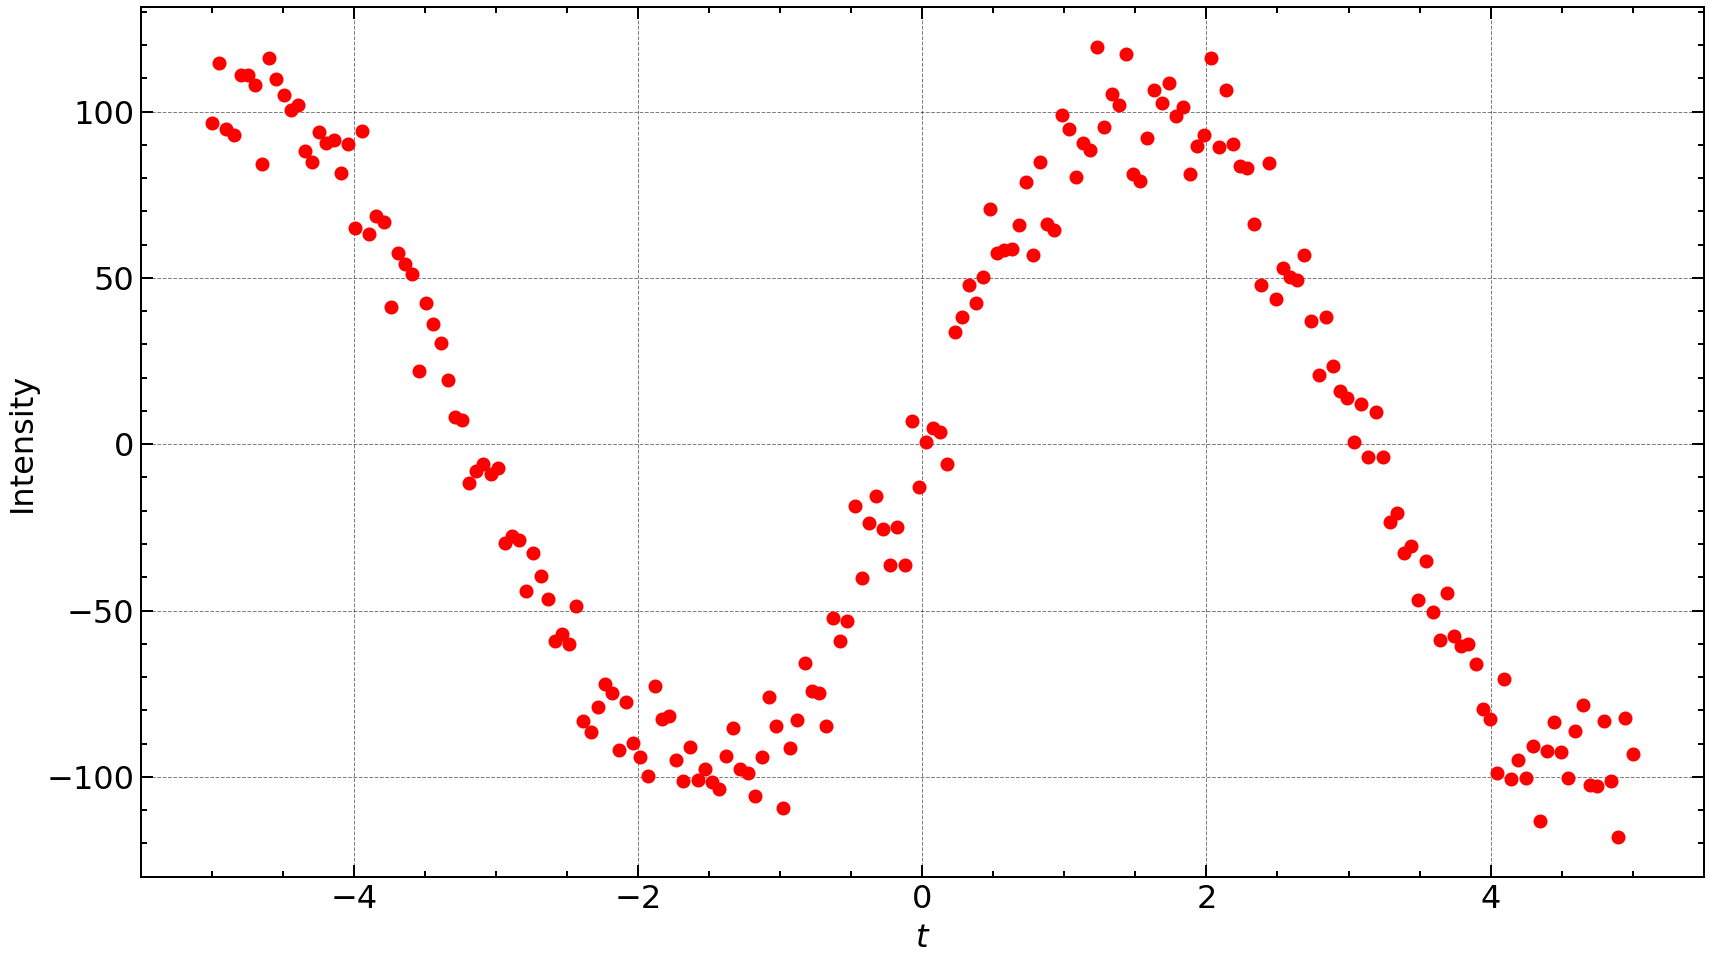

In [4]:
plt.figure(figsize = (14,8), facecolor='w')
plt.scatter(x_data, y_data, c='r')
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

In [5]:
@as_op(itypes=[tt.dscalar, tt.dvector, tt.dscalar], otypes=[tt.dvector])
def tfunc(A, t, t0):
    return A*np.sin(t-t0)

In [6]:
t_shared = theano.shared(x_data)

with pm.Model() as basic_model:
    amp = pm.Normal('A', mu=10, sigma=200)
    σ = pm.HalfCauchy('σ', beta=1)
    t0 = pm.Normal('t0', mu=0, sigma=20, testval=0.)
    mu = tfunc(amp, t_shared, t0) # model-nya (expected value)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=σ, observed=y_data) # likelihood-nya
    

In [7]:
with basic_model:
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=1)
    # trace = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [t0]
>>Slice: [A]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,101.545,1.035,99.567,103.422,0.016,0.011,4057.0,2950.0,1.0
t0,-0.007,0.011,-0.028,0.013,0.000,0.000,4080.0,3010.0,1.0
σ,10.713,0.526,9.699,11.666,0.013,0.009,1741.0,2679.0,1.0


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'t0'}>,
        <AxesSubplot:title={'center':'t0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

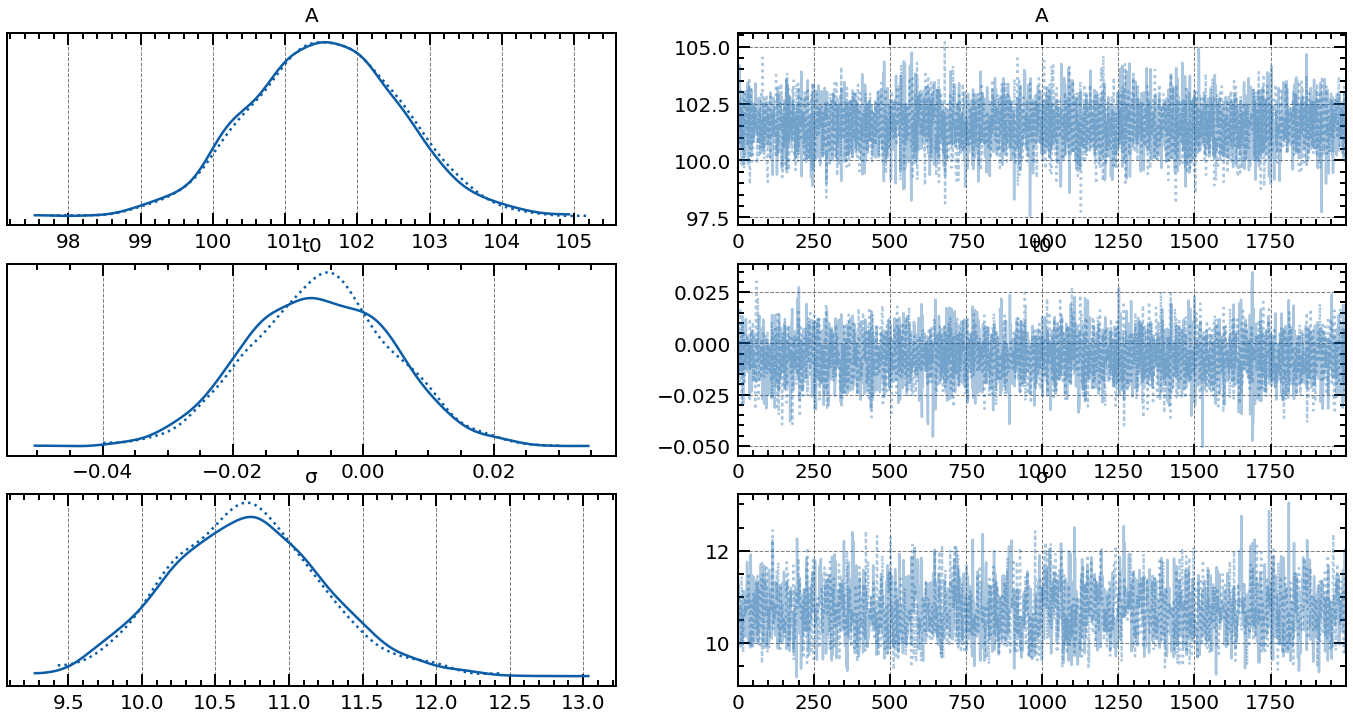

In [9]:
az.plot_trace(trace)

In [10]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).A.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=basic_model)
# data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g, model=model_fresnel)

In [11]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

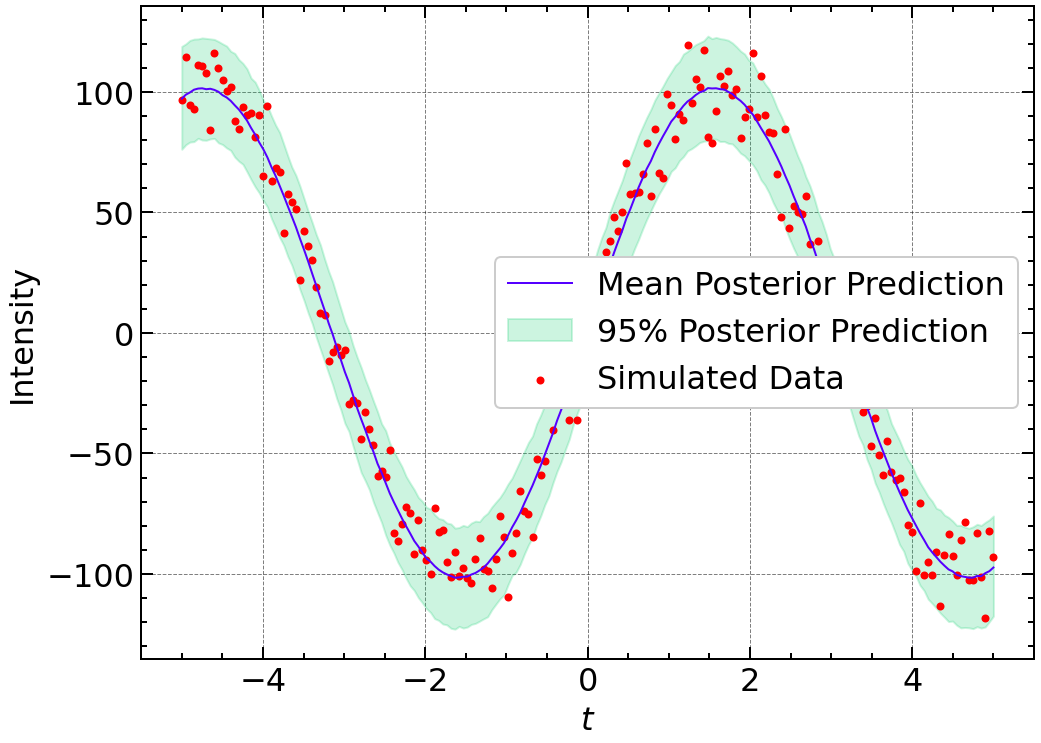

In [12]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))

plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_data, c='r', marker='.')
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

---

In [13]:
# @as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dvector])

def diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

In [29]:
A_true = 100.
t0_true = 0.
v_true = 1.0
σ_true = 10.

np.random.seed(0)

y_data = diffract(x_data, t0_true, A_true, v_true)
y_data = np.random.normal(y_data, scale=σ_true)

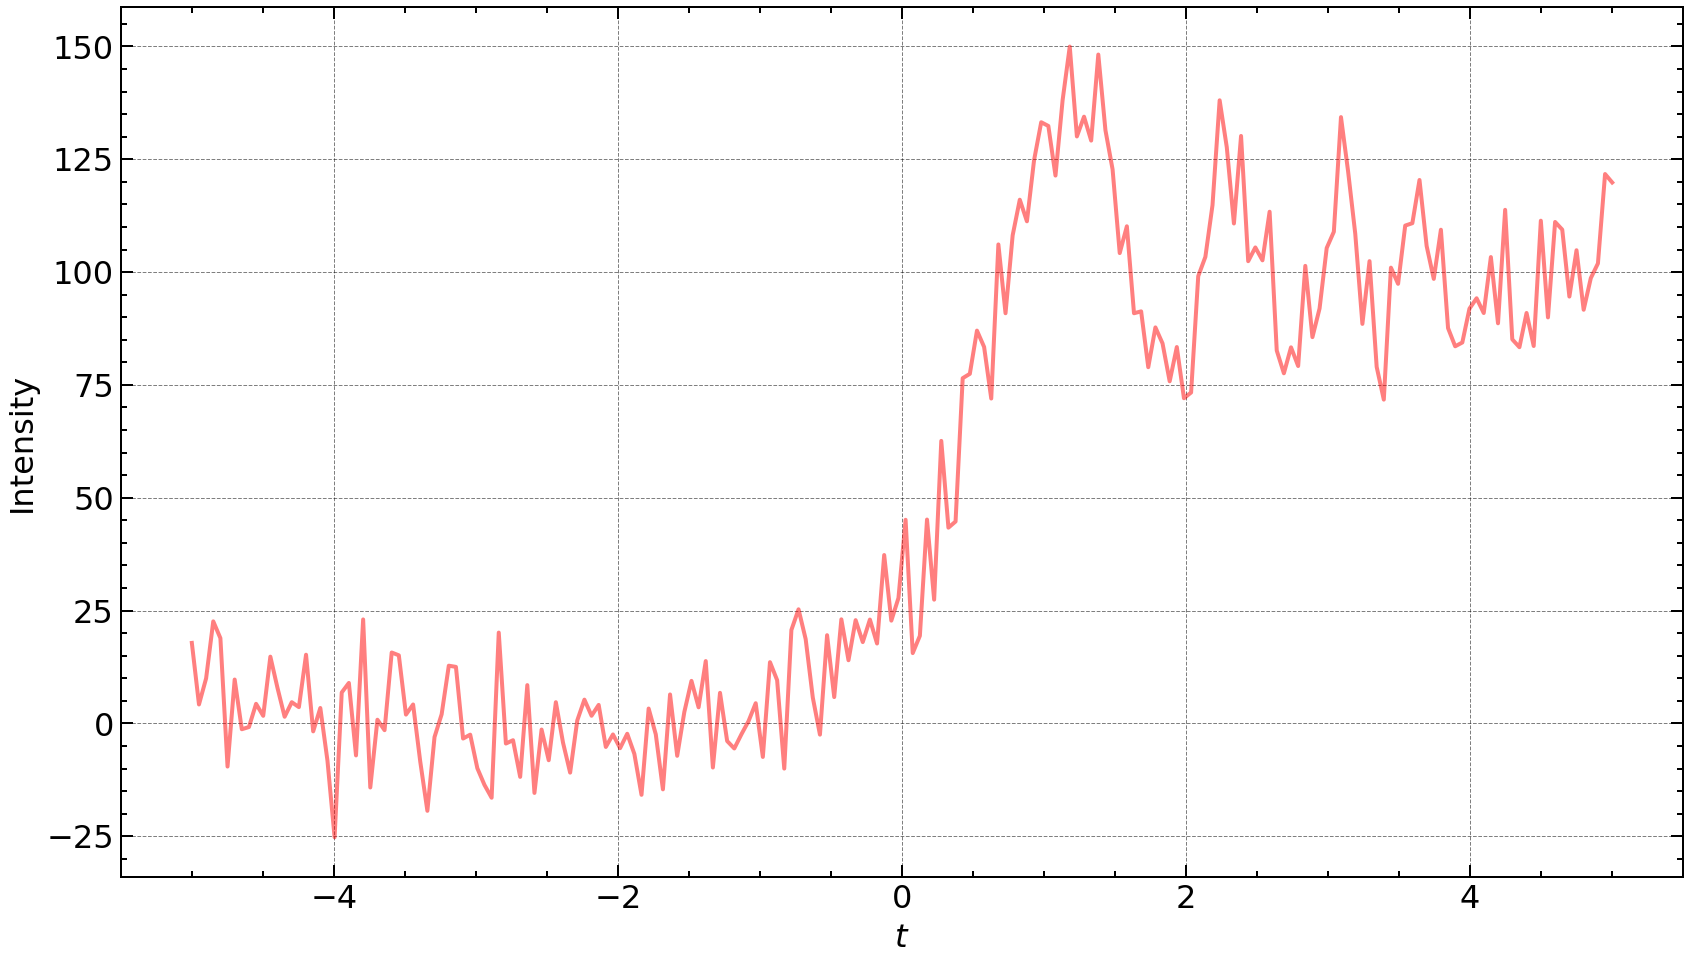

In [52]:
plt.figure(figsize = (14,8), facecolor='w')
# plt.scatter(x_data, y_data, c='r')
plt.plot(x_data, y_data, c='r', alpha=0.5)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.savefig('syn-data-mono-plot.png')

In [16]:
# coords2 = {"obs_idx": np.arange(len(x_data2))}
          
# with pm.Model(coords=coords2) as model_sinus:
#     x = pm.Data("x", x_data2, dims="obs_idx")
#     amp = pm.Normal('A', mu=1, sigma=10)
#     σ = pm.HalfCauchy('σ', beta=1)
#     # mu = diffract(x, t0_true, amp, v_true) # model-nya (expected value)
#     mu = simple_sin(amp, x)
    
#     y = pm.Data("y", y_data2)
#     y_pred = pm.Normal('y_pred', mu=mu, sd=σ, observed=y, dims="obs_idx") # likelihood-nya

# pm.model_to_graphviz(model_sinus)

In [ ]:
# with model_sinus:
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(1000, tune=1000, return_inferencedata=True)

In [ ]:
# az.summary(trace)

In [ ]:
# az.plot_trace(trace, figsize=(14,6))

In [ ]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).A.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_sinus)

In [ ]:
# crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
# crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
# mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

In [ ]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))

#     plt.plot(x_data2, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
#     plt.fill_between(x_data2, crit_l, crit_u, alpha=0.2, color="#00cc66")
#     plt.scatter(x_data2, y_data2, c='r', marker='.')
#     plt.xlabel(r'$t$')
#     plt.ylabel('Intensity')
#     plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

## Catatan terkait *Theano decorator*
Diambil dari: https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html?highlight=arbitrary%20deterministic#Arbitrary-deterministics

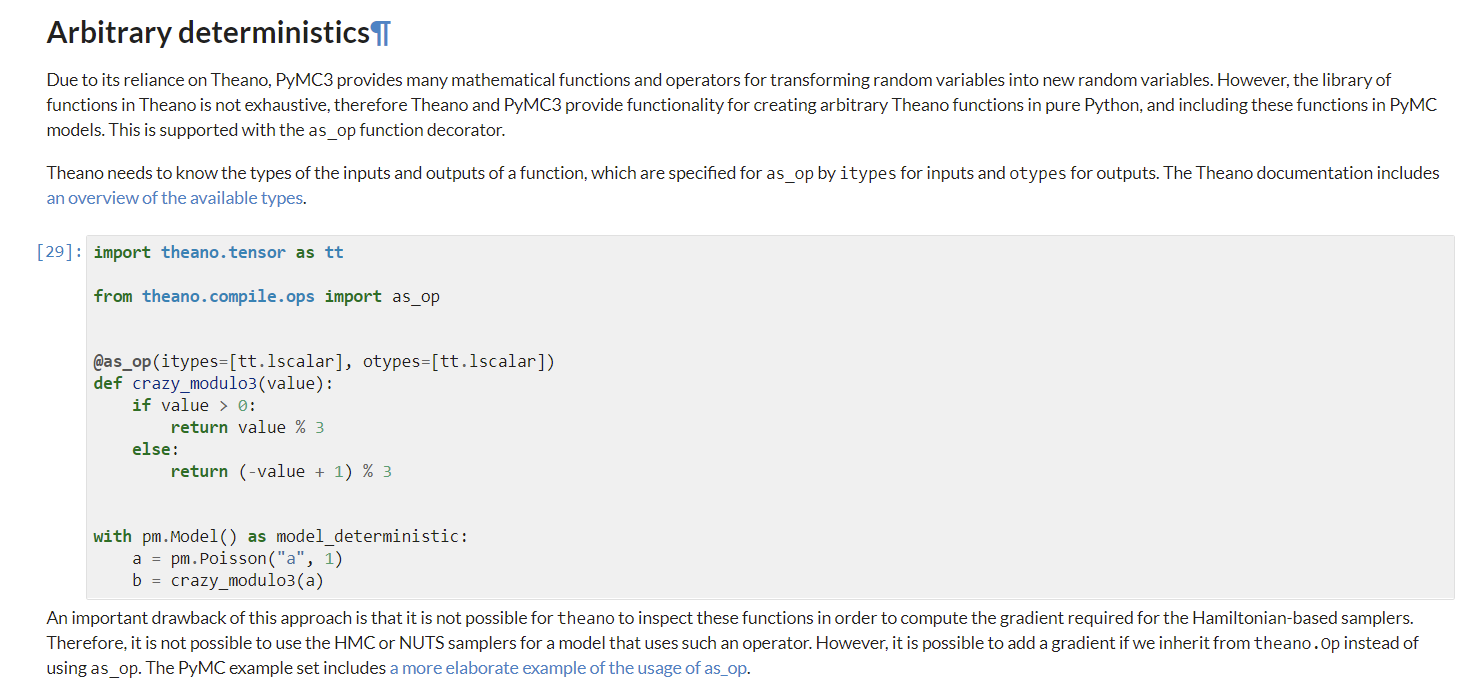

Untuk bisa menggunakan fungsi `Scipy` pada `PyMC3`, maka fungsi tersebut harus dibungkus dalam `Theano` dengan decorator `@as_op`. Opsi lain adalah menulis ulang fungsi yang diinginkan dalam `Theano`.
**Catatan**: `Theano` sudah tidak lagi dikembangkan, diambil alih oleh `PyMC` developer sebagai `Theano - PyMC` / `aesara` (https://github.com/aesara-devs/aesara).

https://discourse.pymc.io/t/use-of-scipy-functions-in-pymc3/1621

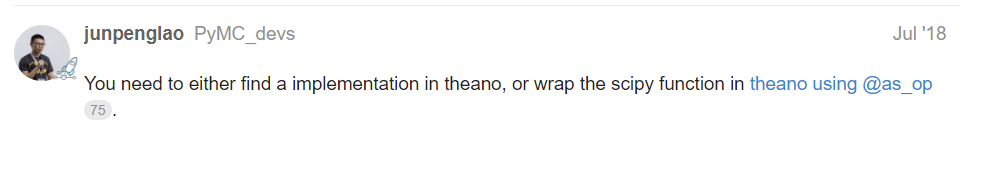

In [31]:
# Fungsi Theano dalam bentuk pure-python. Dijadikan input dalam pembuatan model PyMC3
# -----------------------------------------------------------------------------------
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def t_diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

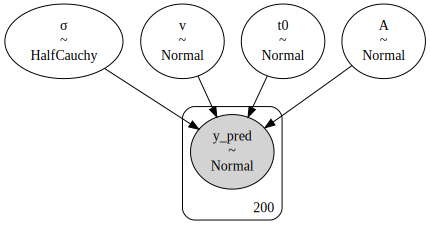

In [32]:
# Karena fungsinya diberi decorator as_op dari Theano, maka inputnya mesti kompatibel dengan Theano
# -------------------------------------------------------------------------------------------------
t_shared = theano.shared(x_data)
t0_shared = theano.shared(t0_true)
v_shared = theano.shared(v_true)


with pm.Model() as model_fresnel:
    amp = pm.Normal('A', mu=90, sigma=20)
    σ = pm.HalfCauchy('σ', beta=1)
    t0 = pm.Normal('t0', mu=0., sigma=20)
    v = pm.Normal('v', mu=1., sigma=10)
    
    mu = t_diffract(t_shared, t0, amp, v) # model-nya (expected value)
    y_pred = pm.Normal('y_pred', mu=mu, sd=σ, observed=y_data) # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [33]:
with model_fresnel:
    prior = pm.sample_prior_predictive()

In [34]:
with model_fresnel:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [v]
>>Slice: [t0]
>>Slice: [A]
>NUTS: [σ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,100.583,1.028,98.738,102.561,0.018,0.013,3203.0,2766.0,1.00
t0,-0.025,0.021,-0.066,0.013,0.001,0.001,424.0,631.0,1.01
v,0.999,0.007,0.984,1.012,0.000,0.000,416.0,825.0,1.01
σ,10.176,0.510,9.170,11.097,0.012,0.008,1894.0,2539.0,1.00


In [36]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).A.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_fresnel)
# data_spp = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=y_pred_g)

array([<AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'t0'}>,
       <AxesSubplot:title={'center':'v'}>,
       <AxesSubplot:title={'center':'σ'}>], dtype=object)

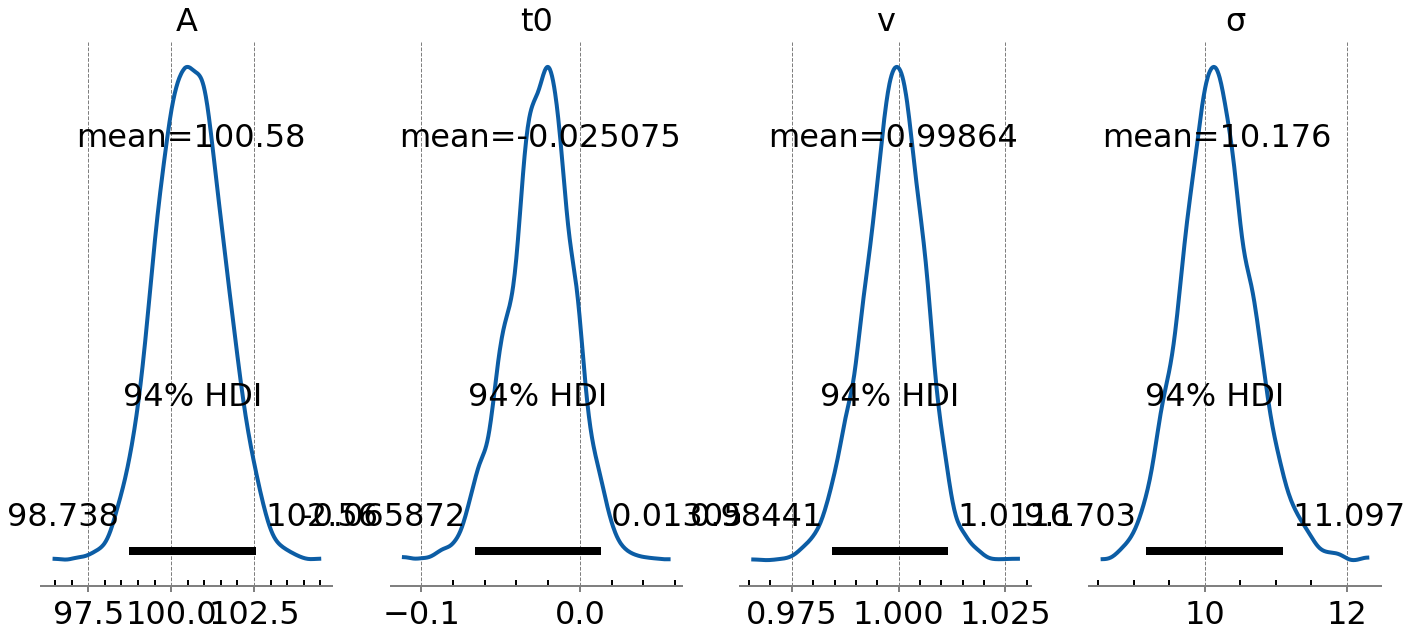

In [37]:
pm.plot_posterior(trace, var_names=None, round_to=5, figsize = (12,5))

In [38]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

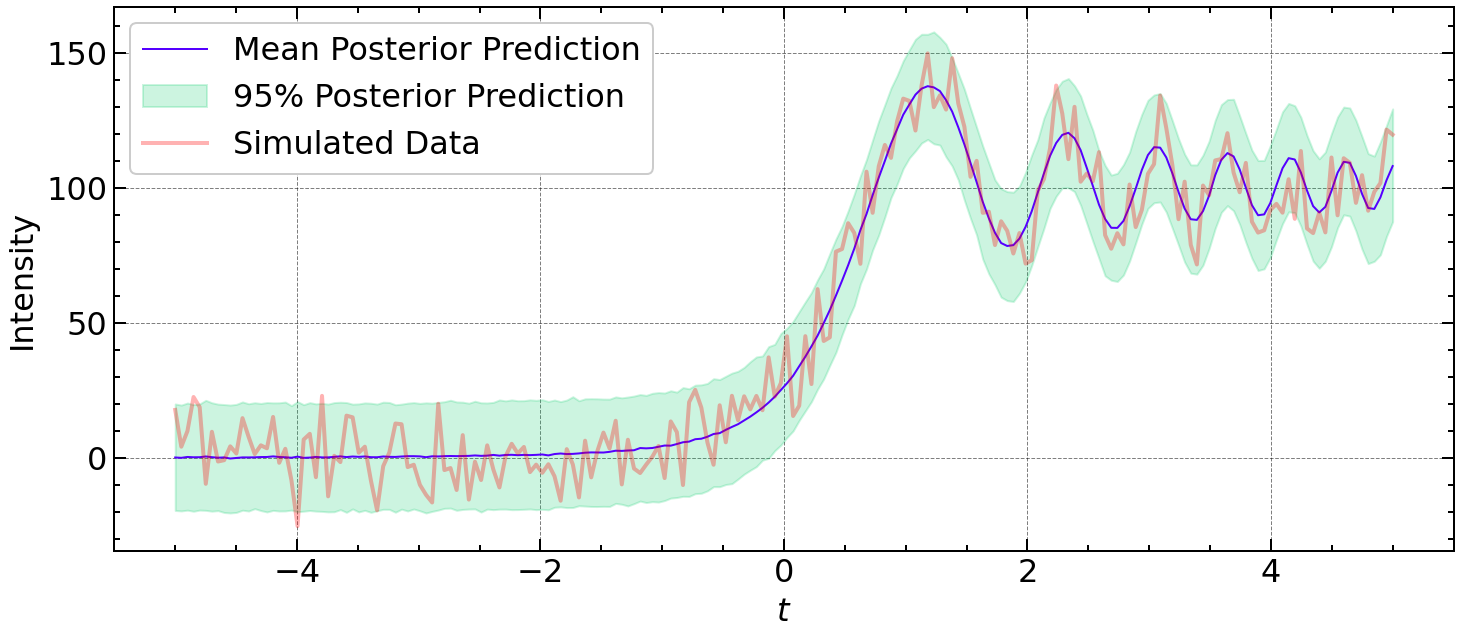

In [55]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
# plt.scatter(x_data, y_data, c='r', marker='.')
plt.plot(x_data, y_data, c='r', alpha=0.3)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

plt.savefig('model-mono-fit.png')

In [40]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

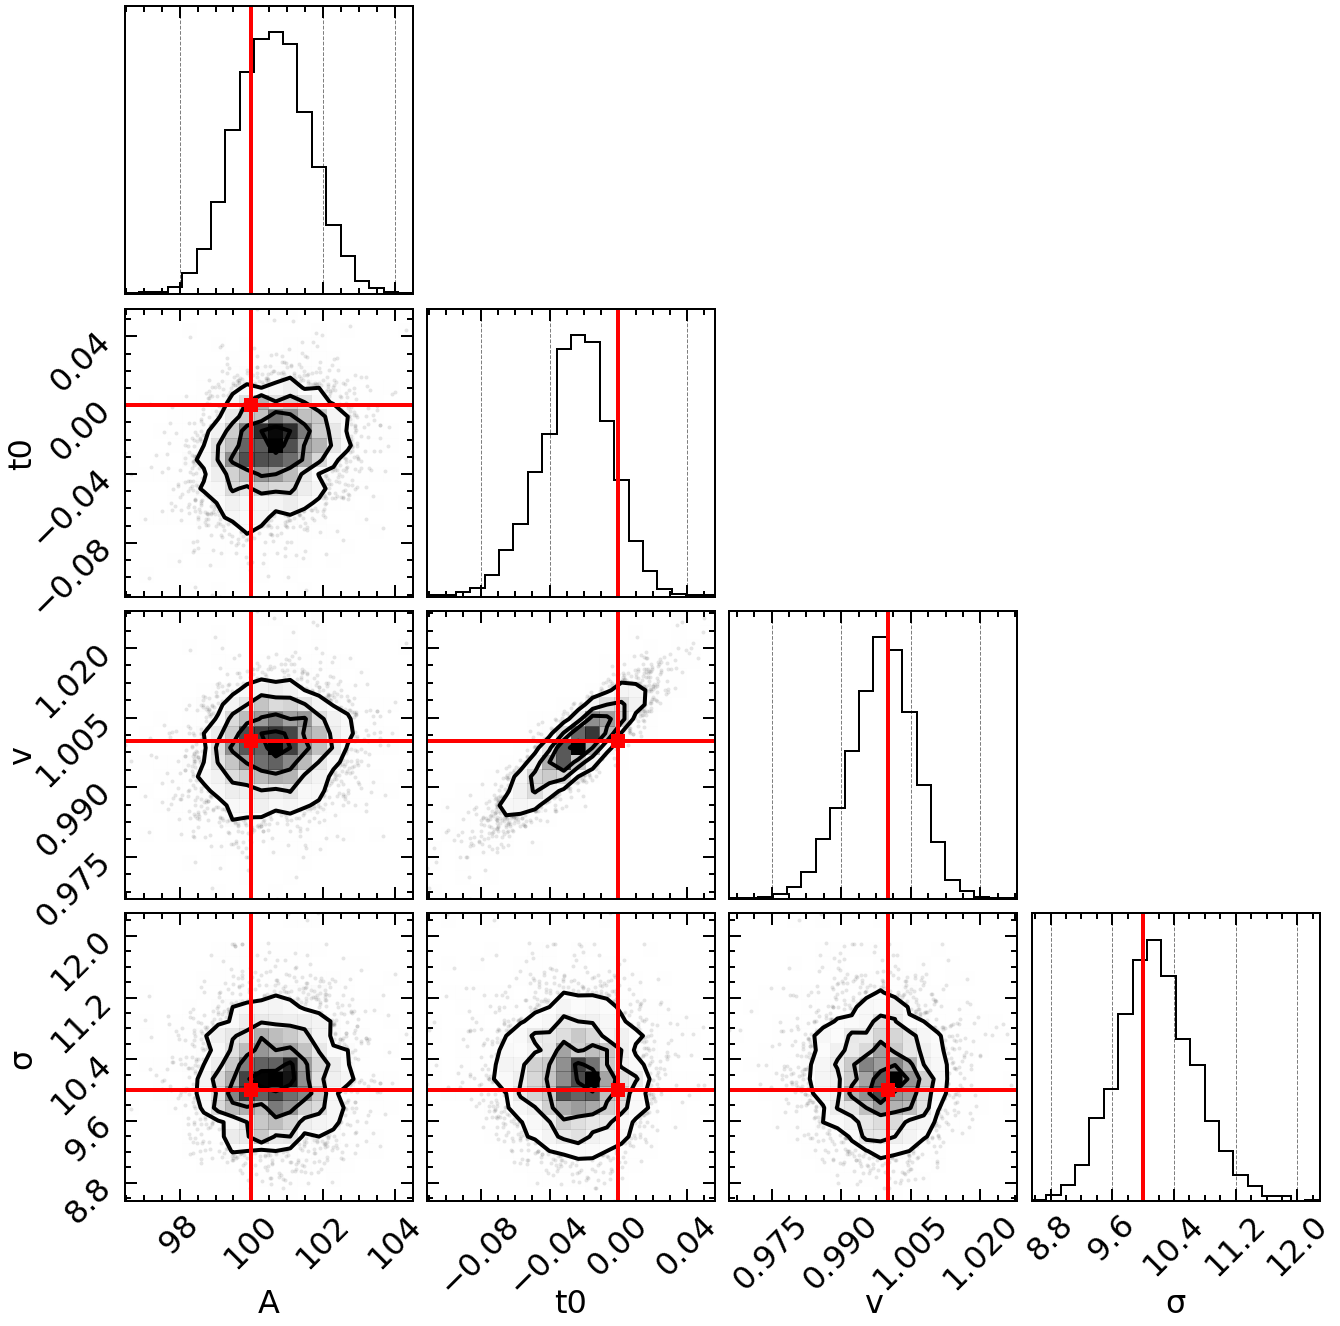

In [41]:
figure = corner.corner(trace, truths=[A_true, t0_true, v_true, σ_true], truth_color='red', divergences=True)

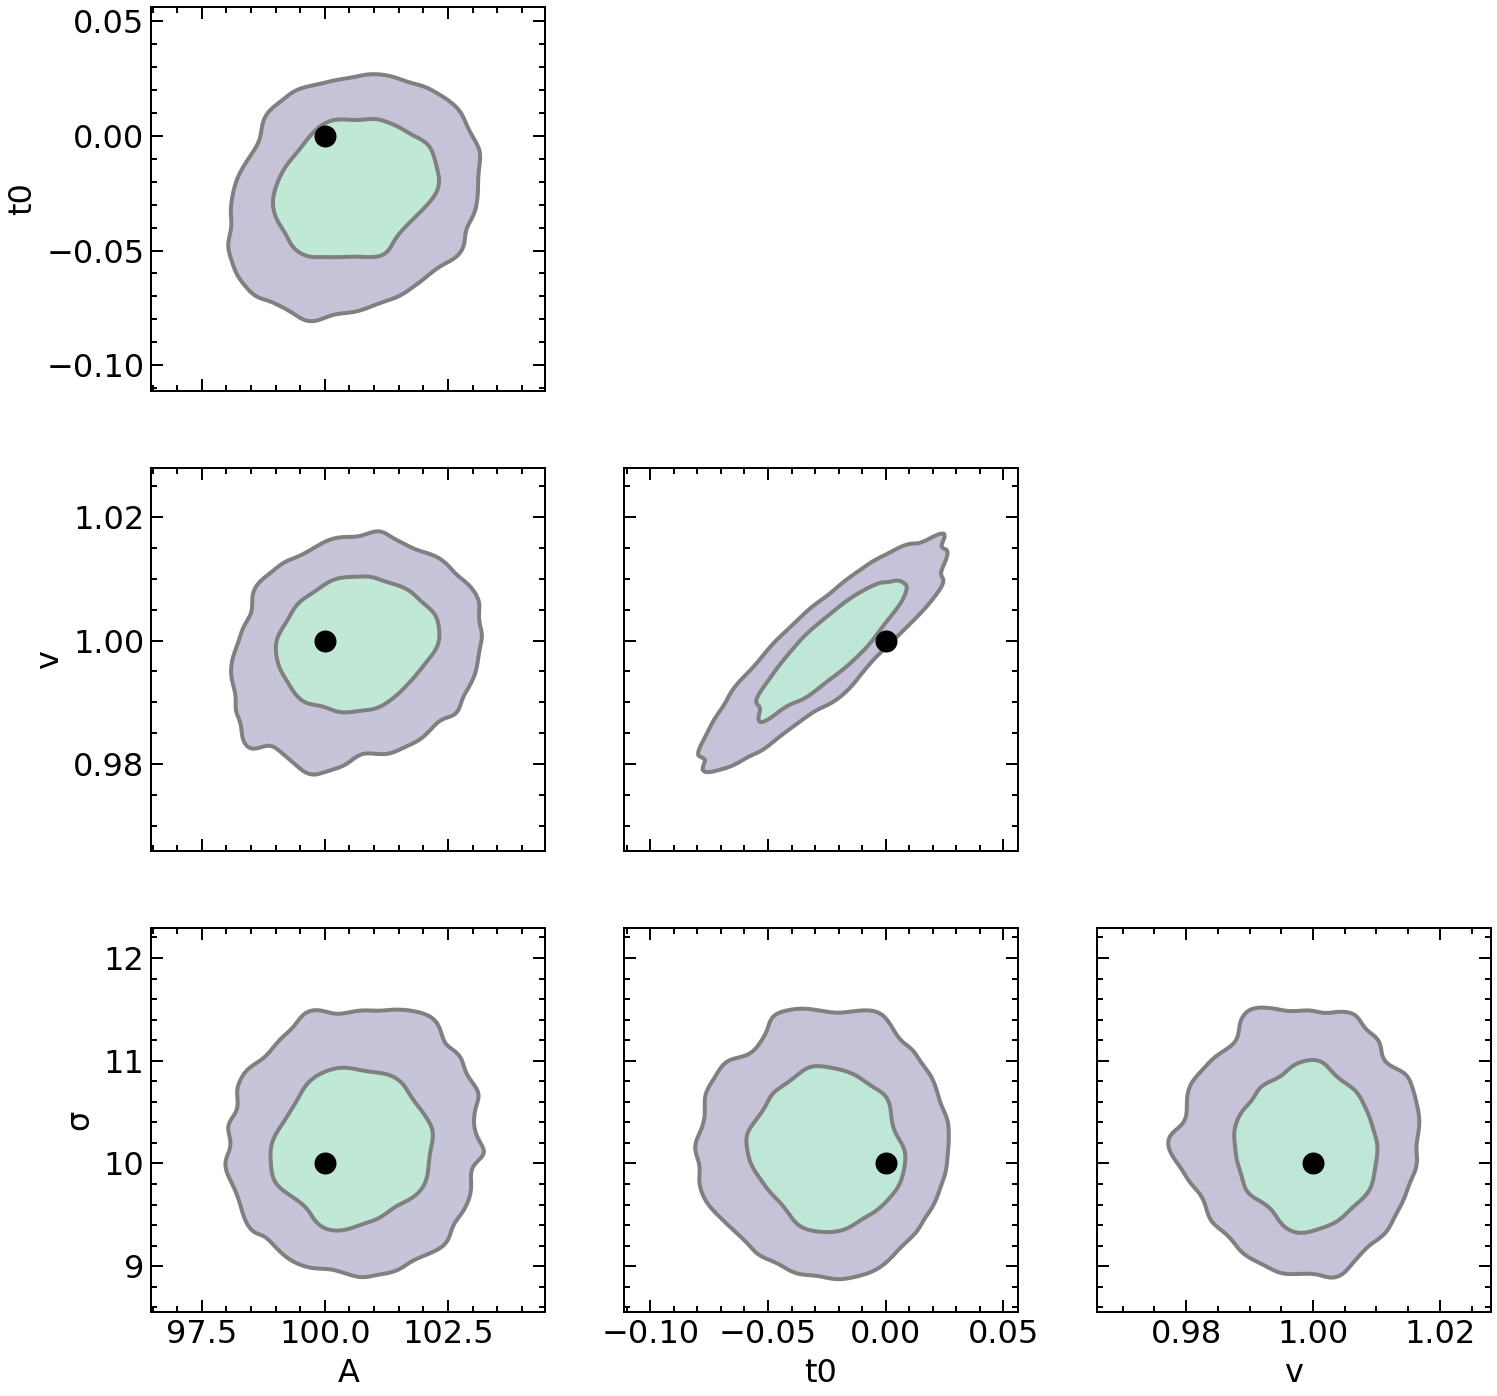

In [46]:
az.plot_pair(
    trace,
    var_names=['A', 't0', 'v', 'σ'],
    kind='kde',
    kde_kwargs={
        "contourf_kwargs": {"alpha": 0.3},
        "hdi_probs": [0.68, 0.95]
    },
    figsize=(12,12),
    divergences=True,
    reference_values={"A":100., "t0": 0., "v": 1., "σ": 10.},
    reference_values_kwargs={"marker": 'o', "ms": 10, "color": "k"},
)
plt.savefig('corner-plot-monokromatik.png')
plt.show()

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'t0'}>,
        <AxesSubplot:title={'center':'t0'}>],
       [<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

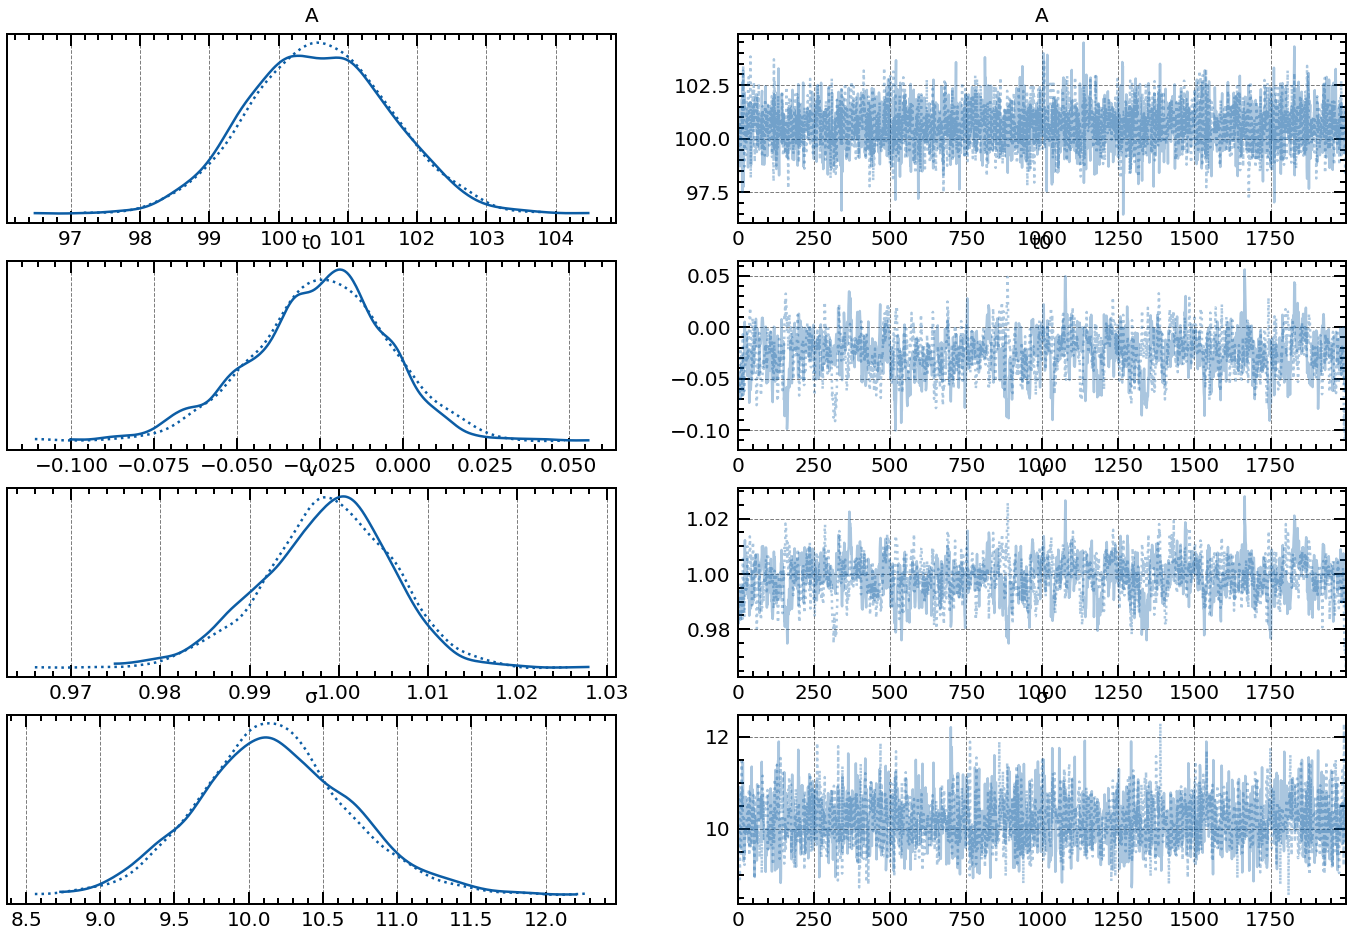

In [43]:
az.plot_trace(trace)

In [44]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jan 28 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.31.0

matplotlib: 3.5.1
corner    : 2.2.1
numpy     : 1.20.3
pymc3     : 3.11.4
scipy     : 1.7.3
arviz     : 0.11.4
pandas    : 1.3.5
theano    : 1.1.2

Watermark: 2.3.0

